# Convolutional Neural Networks - Image classification

We will use Convolutional neural networks to build a simple image classifiers to distinguish cats from dogs

## Mounting Google Drive and loading data

In [ ]:
#connecting to google drive
#for instruction the video under week 8: Act#5_Video Instructions 1_Accessing data via the shared Gdrive link
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#run this cell to unmount google drive
#drive.flush_and_unmount()

In [ ]:
import os
path = '/content/drive/My Drive/Colab Notebooks/data_small_Cats&Dogs'
train_dir = os.path.join(path, 'training_set')
test_dir = os.path.join(path, 'test_set')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')

The folder has the following structure:
*   Training set
>* Cats (1000 pictures)
>* Dogs (1000 pictures)
*   Testing set
>* Cats (200 pictures)
>* Dogs (200 pictures)

This is a subset of the complete dataset, which you can find here https://www.kaggle.com/c/dogs-vs-cats/data. We use a smaller dataset to be able to train the neural network in a reasonable time.

In [ ]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(test_cats_dir)))
print('total validation dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 200
total validation dog images: 200


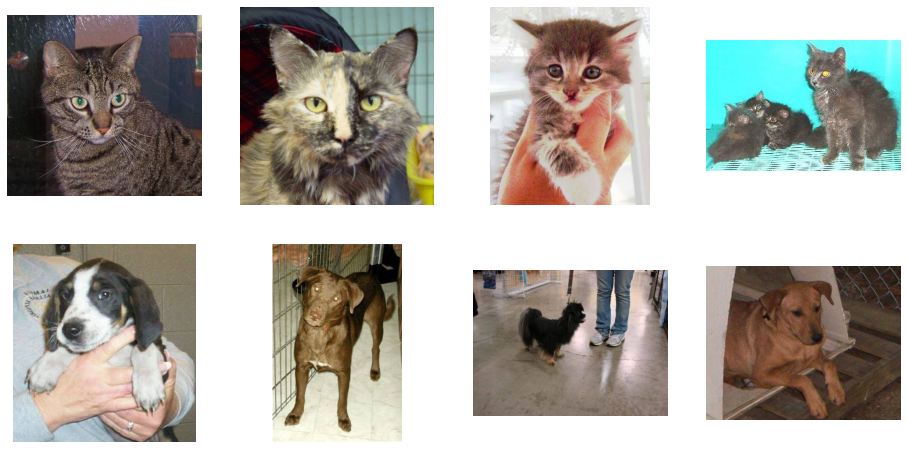

In [ ]:
#let's take a look at few of the pictures
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Parameters for our graph; we'll output images in a 2x4 configuration
nrows = 2
ncols = 4
# Index for iterating over images
pic_index = 0
# Set up matplotlib fig, and size it to fit 2x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 4
next_cat_pix = [os.path.join(train_cats_dir, fname)
                for fname in train_cat_fnames[pic_index-4:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname)
                for fname in train_dog_fnames[pic_index-4:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


## Pre-processing the image data

In [ ]:
%tensorflow_version 2.x
#import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
print(tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.11.0


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#All images will be rescaled by 1./255
#transforms every pixel value from [0,255] to [0,1] to treat all images (low-pixel and high-pixel range) the same
#this is similar to the scaling we did for our ML models, now we have images
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20, #total number of samples in one training step/iteration
        # since we have two outcomes we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


**target_size** is specified depending on the image data and type of images (e.g.,

**batch_size** can be modified as well. Note that we need to have: batch_size * iterations/steps = number of images

## Building a Small Convolutional Neural Network
The images that will go into our convnet are 150x150 color images. When feeding images to Convnets we always need to ensure all images are of the same size. We pad smaller images (e.g., with 0s).

The architecture consists of 2 {convolution + relu + maxpooling} modules (I have excluded the 3rd, uncomment to add it). Our convolutions operate on 3x3 windows (with stride 1) and our maxpooling layers operate on 2x2 windows (with stride 1). Our first convolution extracts 16 filters and the second one extracts 32 filters.
The 3rd one (in case you add it) extracts 64 filters.

NOTE: This is a configuration that is widely used and known to work well for image classification. Also, since we have relatively few training examples (2000), using few convolutional modules keeps the model small, which lowers the risk of overfitting (we will come back to this).

In [ ]:
# NOTE: the syntax we are using is different from the previous NN we built

# Our input image (=input feature map) is 150x150x3:
# 150x150 for the image pixels,
# and 3 for the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution layer extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution layer extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution layer extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
#x = layers.Conv2D(64, 3, activation='relu')(x)
#x = layers.MaxPooling2D(2)(x)

In [ ]:
# Flatten feature map to a 1-dimensional tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 256 nodes
x = layers.Dense(256, activation='relu')(x)

# Dropout can help avoid overfitting on the training data
# Dropout should be added between fully connected layers.
# Add a dropout rate of 0.3
#x = layers.Dropout(0.3)(x)

# we can make the network deeper by adding another dense layer
# this can improve performance but it would take significantly longer time to train the network
# Create a fully connected layer with ReLU activation and 256 nodes
#x = layers.Dense(256, activation='relu')(x)

# Create output layer with a single node and sigmoid activation (since we have binary outcome)
output = layers.Dense(1, activation='sigmoid')(x)
#for multi-class outcome we would use
#output=layers.Dense(number_of_outcomes, activation='softmax')(x)


In [ ]:
# Create the CNN model
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully connected layer + sigmoid output layer
model = Model(img_input, output)

In [ ]:
#Overview of the model
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 41472)             0   

In [ ]:
from tensorflow.keras.optimizers import RMSprop, Adam, Adagrad
#can also try Adam and Adagrad
model.compile(loss='binary_crossentropy',#for multi-class outcome we can use 'categorical_crossentropy'
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy','mae'])

## Training the model
We train the model on the 2000 images for 10 epochs and validate it on the 400 images (in the test set). Notice the steps are set based on the number of images we have.

In [ ]:
#training the CNN; this will take several minutes
history = model.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=10,
      validation_data=test_generator,
      validation_steps=20,  # 400 images = batch_size * steps
      verbose=1)

Epoch 1/10
100/100 [==============================] - 47s 467ms/step - loss: 0.8414 - accuracy: 0.5180 - mae: 0.4960 - val_loss: 0.6820 - val_accuracy: 0.5800 - val_mae: 0.4936
Epoch 2/10
100/100 [==============================] - 45s 448ms/step - loss: 0.6646 - accuracy: 0.6080 - mae: 0.4726 - val_loss: 0.6566 - val_accuracy: 0.6000 - val_mae: 0.4547
Epoch 3/10
100/100 [==============================] - 46s 463ms/step - loss: 0.5860 - accuracy: 0.6815 - mae: 0.4130 - val_loss: 0.6124 - val_accuracy: 0.6450 - val_mae: 0.4322
Epoch 4/10
100/100 [==============================] - 45s 449ms/step - loss: 0.5098 - accuracy: 0.7530 - mae: 0.3533 - val_loss: 0.5606 - val_accuracy: 0.7150 - val_mae: 0.3797
Epoch 5/10
100/100 [==============================] - 49s 484ms/step - loss: 0.4387 - accuracy: 0.7890 - mae: 0.3005 - val_loss: 0.5539 - val_accuracy: 0.7525 - val_mae: 0.3513
Epoch 6/10
100/100 [==============================] - 46s 462ms/step - loss: 0.3574 - accuracy: 0.8505 - mae: 0.244

### Question 1
What is the model's accuracy on the validation/test data after the 5th training epoch? (approximately)

ANSWER: The general model accuracy is 0.9920 i.e., 99%.

Model's accuracy on validation/test data is 0.7000 i.e., 70% After the 5th training epoch

##Saving/Loading trained models
We can save a trained model or just the weights (after training). This is very useful since deep CNN models can take a very long time to train (some famous CNN architectures take days to train on very powerful machines).

If we save only the weights, we need to first create the very same model (same CNN architecture) and then load the saved weights.

In [ ]:
#saving the full model
#model.save('CNN1_fullmodel') #saves the model
#loading a saved model
#model1=tf.keras.models.load_model('CNN1_fullmodel')

#save only model weights so that we can load them after defining the same CNN (without having to retrain it)
#model.save_weights('CNN1_weights')
#load all trained weights
#model.load_weights('CNN1_weights.h5')


## Evaluating Accuracy and Loss for the Model

Plotting the training/validation accuracy and loss as collected during training

Text(0.5, 1.0, 'Training and validation loss')

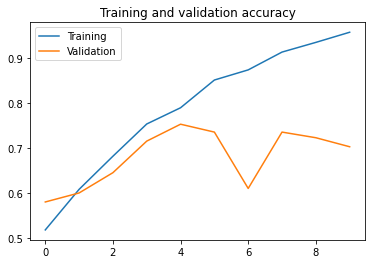

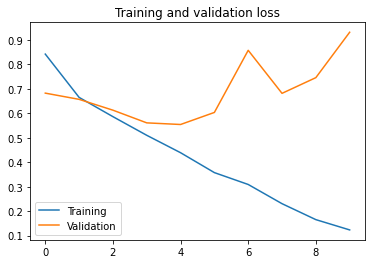

In [ ]:
# Retrieve a list of accuracy results on training and validation data sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and validation data for each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.legend(['Training','Validation'])
plt.title('Training and validation accuracy')
plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.legend(['Training','Validation'])
plt.title('Training and validation loss')

### Question 2
Does the CNN's predictive accuracy improve with more epochs? if so, wen does it converge?


Answer: The training data set shows an improvement in the predictive accuracy, but the test data set shows a poor performance. The CNN's predictive accuracy on the training data collection increases with more epochs.

### Question 3
Do the plots indicate we are overfitting on the training data? how do we know that?

ANSWER: Yes,The training data's accuracy keeps increasing. On the validation data set, the model's performance is not getting any better, though. This indicates that the training data is being overfitted.


## Visualizing Intermediate Representations

To get a feel for what kind of features our convnet has learned, let's visualize how an input gets transformed as it goes through the convnet.

We pick a random cat or dog image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

1/1 [==============================] - 0s 79ms/step


<ipython-input-37-273523bdb9f4>:43: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


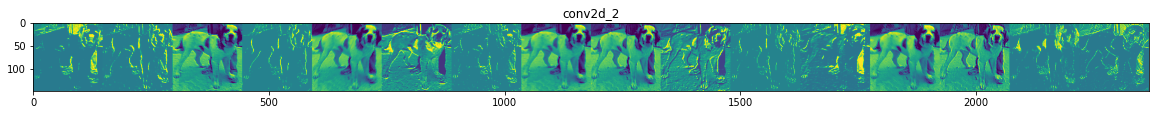

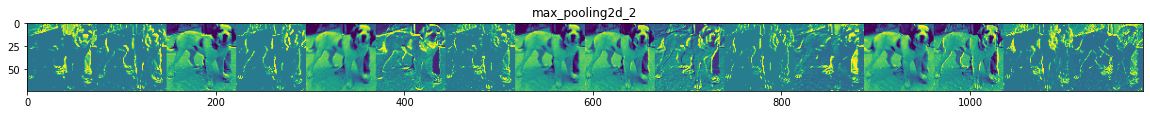

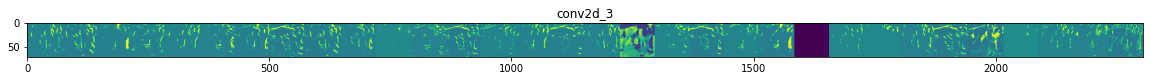

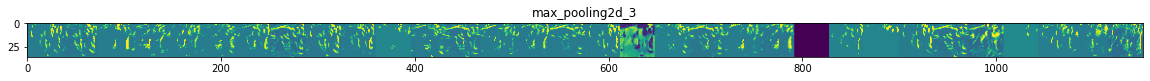

In [ ]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(img_input, successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)

img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)
#x = x.reshape(1, 150, 150, 3)
# Rescale by 1/255
x /= 255

# Run the image through our network and obtain all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]
layer_names.pop(0)
# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) >= 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

## Creating the confusion matrix
Our trained ConvNet is a binary image classifier. Similar to the classification models we did before, we can create a confusion matrix.

In [ ]:
#predicting probability of belonging to outcome class=1 (dogs) for each image in in the test_set
#note that we set batch_size*steps=400 (number of images in our test set)
predict=model.predict(test_generator,batch_size=20,steps=20)
#this may take a while

20/20 [==============================] - 3s 156ms/step


In [ ]:
test_generator.class_indices

{'cats': 0, 'dogs': 1}

In [ ]:
#creating predicted labels 0/1 given probabilities
#if prob>0.5 then outcome=1 [dog]
# else outcome=0 [cat]
y_pred=np.where(predict > 0.5, 1, 0 )
#these are the True labels in out test_set
y_test=test_generator.classes


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

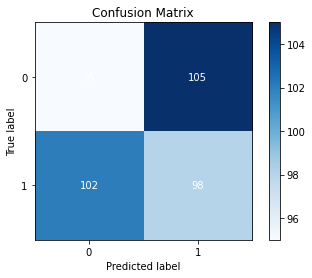

In [ ]:
!pip install Scikit-plot
import scikitplot as skplt
#confusion matrix for CNN classifier
skplt.metrics.plot_confusion_matrix(y_test, y_pred,normalize=False)

## Classify a new image
There are 4 images in the shared folder (starting with "new_") outside of the train and test folders.
Let's see what out trained CNN classifies each as.

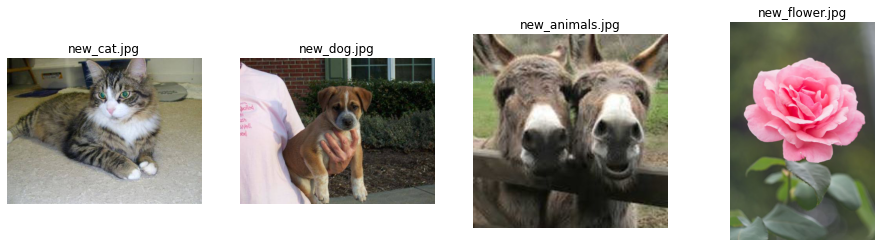

In [ ]:
#here are the 4 new images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
pic_names=list()
path_names=list()
for file in os.listdir(path):
    if file.endswith(".jpg"):
        path_names.append(os.path.join(path,file))
        pic_names.append(file)

fig = plt.gcf()
fig.set_size_inches(16, 4)
#img = mpimg.imread(pic_names[0])
#plt.imshow(img)

for i,img_path in enumerate(path_names):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(1, 4, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.title(pic_names[i])
plt.show()

In [ ]:
#Remember our model is only able to distinguish between dogs and cats
train_generator.class_indices

{'cats': 0, 'dogs': 1}

In [ ]:
#from tensorflow.keras.preprocessing.image import img_to_array, load_img
#change the file name to feed each image to the model
filename=os.path.join(path,'new_cat.jpg') #change the file name
# Notice that we need to do the same pre-processing on our new images
#load and resize new image
img = load_img(filename, target_size=(150, 150))
# convert to array
img = img_to_array(img)
# reshape into a single sample with 3 channels
img = img.reshape(1, 150, 150, 3)
# Rescale by 1/255
img=img/255

#predict label for new input
model.predict(img) #probability of image being outcome_class=1 [dog]

1/1 [==============================] - 0s 28ms/step


array([[0.9090247]], dtype=float32)

###Question 4
Does our ConvNet correctly classfy the new dog picture?


ANSWER: Yes.

###Question 5
Does our ConvNet correctly classfy the new cat picture?


ANSWER: No.

### Question 6
What does the model classify the other images as?


ANSWER: The model classifies the other images as dogs.

# Improving the model

To improve model performance we can do several things:
* Adding Data augmentation and Dropout to avoid overfitting - will try
* More training data - won't do
* Change the CNN to include more layers (convolutional and dense) - will try

With more training data and a deeper Convnet architecture can increase training time significantly.

In [ ]:
#deletes the model and clears tf session
#tf.keras.backend.clear_session()
#del model

##Data Augmentation
Image augmentation is a powerful technique to artificially create variations in input images by augmenting them via a number of random transformations, so that at training time, our model will never see the exact same picture twice. This helps prevent overfitting and helps the model generalize better.
Possible tranformations include, zooming the existing image, horizontal and vertical shift, horizontal and vertical flipping, random rotation, random brightness augmentation, etc.


In [ ]:
#implementing augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen2 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,     #randomly rotating the image by 0 to 40 degrees
    width_shift_range=0.2, #randomly shifting the image right/left by 0.2 the fraction of the image width
    height_shift_range=0.2,#randomly shifting the image up/down by 0.2 the fraction of the image height
    zoom_range=0.5,         #randomly magnify the image (zoom_range<1)
    horizontal_flip=True,) #randomly horizontal flip the image

# Note that the validation data should not be augmented! we use it to evaluate model performance
val_datagen2 = ImageDataGenerator(rescale=1./255)

#  training images in batches of 20 using train_datagen generator
train_generator2 = train_datagen2.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        class_mode='binary')

# validation images in batches of 20 using val_datagen generator
test_generator2 = val_datagen2.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


##Dropout
Dropout is a regularization for reducing overfitting in neural networks. During training, some number of units in a layer are randomly ignored or "dropped out". By dropping a unit out, we mean temporarily removing it from the network, along with all its incoming and outgoing connections.
Dropout has the effect of making the training process noisy, forcing nodes within a layer to probabilistically take on more or less responsibility for the inputs, which in turn makes the model more robust.
Since the outputs of a layer under dropout are randomly subsampled, it has the effect of reducing the capacity or thinning the network during training. Therefore, a wider network, e.g. more nodes, may be required when using dropout.

For Convolutional NNs, we do not use dropout between the convolutinal (or pooling) layers but between the fully connected layers.

## Retraining the model with improvements
We will now add these improvements and retrain the model.


In [ ]:
!pip install -q git+https://github.com/tensorflow/docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

  Preparing metadata (setup.py) ... done


In [ ]:
# 150x150 for the image pixels, and 3 for the three color channels RGB
img_input = layers.Input(shape=(150, 150, 3))

# First convolution layer extracts 16 filters that are 3x3
# followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution layer extracts 32 filters that are 3x3
# followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution layer extracts 64 filters that are 3x3
# followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dimensional tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 256 nodes
x = layers.Dense(256, activation='relu')(x)

# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)

# Create a fully connected layer with ReLU activation and 256 nodes
x = layers.Dense(256, activation='relu')(x)

#you can add another dropout here

# Create output layer with a single node and sigmoid activation (since we have binary outcome)
output = layers.Dense(1, activation='sigmoid')(x)

# Create the CNN model
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully connected layer + sigmoid output layer
model2 = Model(img_input, output)

In [ ]:
model2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 64)        1849

In [ ]:
#setting up the loss function and optmizer
from tensorflow.keras.optimizers import RMSprop, Adam, Adagrad
#can also try Adam and Adagrad
model2.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy','mae'])

In [ ]:
#training the CNN; this will take several minutes
history2 = model2.fit(
      train_generator2,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=10,
      validation_data=test_generator2,
      validation_steps=20,  # 400 images = batch_size * steps
      verbose=1,
      callbacks=[tfdocs.modeling.EpochDots()])

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.7088 - accuracy: 0.5135 - mae: 0.4996
Epoch: 0, accuracy:0.5135,  loss:0.7088,  mae:0.4996,  val_accuracy:0.5850,  val_loss:0.6892,  val_mae:0.4980,  
100/100 [==============================] - 54s 530ms/step - loss: 0.7088 - accuracy: 0.5135 - mae: 0.4996 - val_loss: 0.6892 - val_accuracy: 0.5850 - val_mae: 0.4980
Epoch 2/10
100/100 [==============================] - 52s 521ms/step - loss: 0.6935 - accuracy: 0.5410 - mae: 0.4966 - val_loss: 0.7176 - val_accuracy: 0.5300 - val_mae: 0.4909
Epoch 3/10
100/100 [==============================] - 51s 509ms/step - loss: 0.6754 - accuracy: 0.5840 - mae: 0.4799 - val_loss: 0.6664 - val_accuracy: 0.5750 - val_mae: 0.4719
Epoch 4/10
100/100 [==============================] - 52s 515ms/step - loss: 0.6559 - accuracy: 0.5935 - mae: 0.4636 - val_loss: 0.6419 - val_accuracy: 0.6400 - val_mae: 0.4484
Epoch 5/10
100/100 [==============================] - 54s 535ms/step - loss: 0.6

In [ ]:
model2.save('CNN2_fullmodel')

## Evaluating Accuracy and loss for model2

Text(0.5, 1.0, 'Training and validation loss')

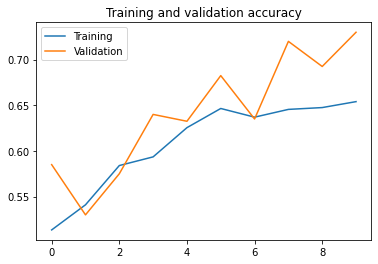

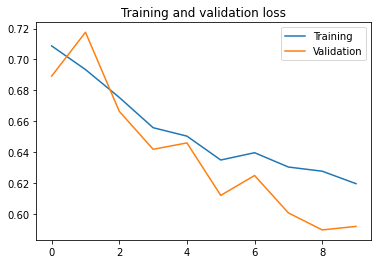

In [ ]:
# Retrieve a list of accuracy results on training and validation data sets for each training epoch
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

# Retrieve a list of list results on training and validation data for each epoch
loss = history2.history['loss']
val_loss = history2.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.legend(['Training','Validation'])
plt.title('Training and validation accuracy')
plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.legend(['Training','Validation'])
plt.title('Training and validation loss')

### Question 7
Does the new convnet arhictecture have a better performance? how do you know?

ANSWER: Yes, the new convnet architecture performs better because the new model is becoming more accurate during both training and validation. Both the validation loss and training loss are decreasing at the same moment. The training data collection did not cause the model to overfit. That is how we know the new design performs better.

##Classify the new images with the new model
Let's see whether the new Convnet model classifies new cat and dog images correctly

In [ ]:
#from tensorflow.keras.preprocessing.image import img_to_array, load_img
#change the file name to feed each image to the model
filename=os.path.join(path,'new_cat.jpg') # 'new_dog.jpg'
# Notice that we need to do the same pre-processing on our new images
#load and resize new image
img = load_img(filename, target_size=(150, 150))
# convert to array
img = img_to_array(img)
# reshape into a single sample with 3 channels
img = img.reshape(1, 150, 150, 3)
# Rescale by 1/255
img=img/255

#predict label for new input
model2.predict(img)

1/1 [==============================] - 0s 33ms/step


array([[0.40507966]], dtype=float32)

# Bonus Question (optional - not discussed on slides)
With any neural network classifier, the trained model can be used to predict the probability of a new input (image) belonging to one (or multiple) outcome classes.

For example, assume a Convnet is trained to identify 100 different objects (obj1 to obj100). We feed it a new image of an object that isn't any of the 100 objects it can identify, however it will still label it as some of the 100 objects it knows (with different probabilities). In our simple example the image of a flower is incorrectly classified as either a dog or cat, since our model noly knows two outcomes.

Would the performance metrics we discussed for a NN far (e.g., accuracy, precision, etc.) be able to tell us when we face such a scenario?
...

What metric do you think would be needed to address this problem?

...



Answer: The uncertainity metric would be needed to address this problem.